In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Data.Library import Library
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
#torch.cuda.get_device_name()

In [ ]:
class S4Model(nn.Module):
    def __init__(self, vocab_size, d_model, d_internal, num_layers, device = torch.device('cpu')):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.d_internal = d_internal
        self.num_layers = num_layers
        self.device = device
        self.log_softmax = nn.LogSoftmax(-2)

        # Define model shape
        self.embeddings = nn.Embedding(self.vocab_size, self.d_model).to(self.device)
        self.S4_layers = nn.ModuleList()
        self.num_params = self.vocab_size*self.d_model
        for layer in range(self.num_layers):
            self.S4_layers.append(S4Layer(latent_size = self.d_internal, in_channels = self.d_model, out_channels = self.d_model, device=self.device))
            self.num_params += self.S4_layers[-1].num_params
        self.fc1 = nn.Linear(self.d_model, self.vocab_size).to(self.device)
    def forward(self, sequence, conv=False):
        batch_size, seq_length = sequence.shape
        x = self.embeddings(sequence)
        # Current shape is [batch_size, sequence_length, channels]
        x = x.permute(0, 2, 1)#.to(self.device)
         # Current shape is [batch_size, channels, sequence_length]
        for layer in self.S4_layers:
            x = layer(x, conv=conv)
            x = F.relu(x)
        t1 = time.time()
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = x.permute(0, 2, 1)
        x = self.log_softmax(x)
        return x
class S4Layer(nn.Module):
    def __init__(self, latent_size=8, in_channels = 1, out_channels=10, device=torch.device('cpu')):
        super().__init__()
        self.latent_size = latent_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.device = device

         # Use hippo matrices for A and B
        self.A = self.gen_A(self.latent_size)
        self.B = self.gen_B(self.latent_size)
        self.C = nn.Linear(self.in_channels*self.latent_size, self.out_channels).to(self.device)
        self.D = nn.Linear(self.in_channels, self.out_channels).to(self.device)
        self.A_stack = None
        self.step = None
        self.A_bar = None
        self.B_bar = None
        self.B_scale = self.B.unsqueeze(0).unsqueeze(2).to(self.device)
        self.log_softmax = nn.LogSoftmax(-1)
        self.num_params = self.in_channels*(self.latent_size + 1)*self.out_channels + self.latent_size**2 + self.latent_size # Last two terms include hippo matrices

    def gen_A(self, N):
        A = torch.zeros(N, N)
        for n in range(N):
            for k in range(N):
                if n > k:
                    A[n, k] = -(2*n + 1)**.5 * (2*k + 1)**.5
                elif n == k:
                    A[n, k] = -(n+1)
        return A
        
    def gen_B(self, N):
        B = torch.zeros(N)
        for n in range(N):
            B[n] = (2*n+1)**.5
        return B.unsqueeze(1)
        
    def discretize(self, step):
        if self.step == step and self.B_bar is not None and self.A_bar is not None:
            return self.A_bar, self.B_bar
        else:
            A = self.A.to('cpu')
            B = self.B.to('cpu')
            N = A.shape[0]
            I = torch.eye(N)
            A_bar = torch.linalg.solve_triangular(I - (step / 2.0) * A, (I + (step / 2.0) * A), upper=False).to(self.device)
            B_bar = torch.linalg.solve_triangular((I - (step / 2.0) * A), B * step, upper=False).to(self.device)
            self.step = step
            self.A_bar = A_bar
            self.B_bar = B_bar                                                                                                        
            return self.A_bar, self.B_bar
    
    def get_legendre_kernel(self, seq_length):
        if self.A_stack is None or self.step != 1.0/seq_length:
            A_stack = torch.eye(self.latent_size).unsqueeze(-1).repeat((1, 1, seq_length)).permute(2, 0, 1).to(self.device)
            A_bar, B_bar = self.discretize(step=1.0/seq_length)
            for idx in range(0, seq_length):
                A_stack[:idx] = A_stack[:idx] @ A_bar
            A_stack = A_stack.permute(1, 2, 0).cpu()
            self.A_stack = A_stack.unsqueeze(2).to(self.device)
            return self.A_stack
        else:
            return self.A_stack
            
    def get_legendre_rec(self, sequence):
        batch_size, in_channels, seq_length = sequence.shape
        x = torch.zeros([batch_size, self.latent_size, in_channels,  seq_length + 1]).to(self.device)
        A_bar, B_bar = self.discretize(step=1.0/seq_length)
        B_bar = B_bar.permute(1, 0).repeat(batch_size, 1).unsqueeze(2) # Shape of [batch_size, latent_sizem, 1]
        A_bar = A_bar.unsqueeze(0).repeat(batch_size, 1, 1)
        for idx in range(seq_length):
            seq = sequence[:,:,idx].unsqueeze(1)
            B_term = torch.matmul(B_bar, seq)
            x_term = x[:,:,:,idx]
            A_term = torch.matmul(A_bar, x_term)
            x[:, :, :, idx+1] = A_term + B_term
        # x has shape [batch_size, self.latent_size, in_channels, seq_length + 1]
        output = x[:, :, :, 1:]
        # output has shape [batch_size, self.latent_size, in_channels, seq_length]
        B_scale = self.B.unsqueeze(0).unsqueeze(2).to(self.device)
        # output has shape [batch_size, in_channels, latent_size, sequence_length]
        output = (B_scale * output).permute(0, 2, 1, 3)
        return output
    
    def get_legendre_conv(self, sequence):
        # Sequence of shape [batch_size, in_channels, seq_length]
        batch_size, in_channels, seq_length = sequence.shape
        A_bar, B_bar = self.discretize(step = 1.0/seq_length)
        # Apply B
        u = sequence
        u = B_bar.unsqueeze(0).unsqueeze(2) * u.unsqueeze(1)
        # Convolution
        output = F.conv2d(u, self.get_legendre_kernel(seq_length), padding=(0, seq_length-1))[:, :, :, :seq_length]
        # output has shape [batch_size, self.latent_size, in_channels, seq_length]
        # output has shape [batch_size, in_channels, latent_size, sequence_length]
        output = (self.B_scale * output).permute(0, 2, 1, 3)
        return output
    
    def forward(self, u, conv=True):
        # u has shape [batch_size, in_channels, sequence_length]
        if len(u.shape) == 2: # If 1 dimensional
            u = u.unsqueeze(1)
        if conv:
            output = self.get_legendre_conv(u.to(self.device))
        else:
            output = self.get_legendre_rec(u.to(self.device))
        # output has shape [batch_size, in_channels, latent_size, sequence_length]
        # output permuted to [batch_size, seq_length, in_channels, latent_size]
        # Flatten feature space to [batch_size, seq_length, in_channels * latent_size]
        output = output.permute(0, 3, 1, 2).flatten(2).detach()
        output =  self.C(output) + self.D(u.permute(0, 2, 1))
        # output should now be of shape [batch_size, seq_length, out channels]
        return output.permute(0, 2, 1)

In [ ]:
# Hyperparams
epochs = 64
lr = .001
seq_length=256
batch_size=64
d_model=16
d_internal=16
num_layers=1
train_size = 2**20
test_size = 2**16
encoding = 76
vocab_size = 76
conv = True
torch.manual_seed(0)
# Setup
device = torch.device('mps')
library = Library(encoding=encoding, train_size=train_size, test_size=test_size, download_new=False)
model = S4Model(vocab_size, d_model, d_internal, num_layers, device)
print(f'S4 Model with {model.num_params} parameters')
loss_fn = nn.NLLLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)
x_batch = torch.zeros([batch_size, seq_length-1])
y_batch = torch.zeros([batch_size, seq_length-1])
losses = torch.zeros(epochs).to(device)
perplexities = torch.zeros(epochs)
print('Training')
tic = time.time()
# Training
for epoch in range(epochs):
    dataloader = library.get_train_dataloader(seq_length)
    for idx, data in enumerate(dataloader):
        mod_idx = idx % batch_size
        if data.shape[0] != seq_length:
            break # End of usable dataloader
        x_batch[mod_idx] = data[:-1]
        y_batch[mod_idx] = data[1:]
        if mod_idx == batch_size-1:
            # Update weights
            optim.zero_grad()
            y_pred = model(x_batch.long().to(device), conv=conv)
            loss = loss_fn(y_pred, y_batch.long().to(device))
        
            losses[epoch] += loss

            print(f'{epoch}:{idx+1}:{losses[epoch]:.4f}', end='\r')
            loss.backward()
            optim.step()
            
    # Test
    perplexities[epoch] = library.calc_perplexity(model, batch_size=64, seq_length=256)
    print(f'{epoch}:Total Loss:{losses[epoch]:.2f}:Perplexity:{perplexities[epoch]:.2f}')
print(time.time()-tic)

S4 Model with 5840 parameters
Training
0:Total Loss:253.99:Perplexity:33.64
1:Total Loss:196.62:Perplexity:16.67
2:Total Loss:171.26:Perplexity:13.86
3:Total Loss:162.19:Perplexity:12.49
4:Total Loss:156.53:Perplexity:11.66
5:Total Loss:152.79:Perplexity:11.12
6:Total Loss:150.22:Perplexity:10.75
7:Total Loss:148.36:Perplexity:10.48
8:Total Loss:146.91:Perplexity:10.27
9:Total Loss:145.72:Perplexity:10.10
10:Total Loss:144.73:Perplexity:9.96
11:Total Loss:143.87:Perplexity:9.85
12:Total Loss:143.14:Perplexity:9.75
13:Total Loss:142.50:Perplexity:9.67
14:Total Loss:141.93:Perplexity:9.60
15:Total Loss:141.43:Perplexity:9.53
16:Total Loss:140.98:Perplexity:9.47
17:Total Loss:140.56:Perplexity:9.42
18:Total Loss:140.18:Perplexity:9.37
19:Total Loss:139.83:Perplexity:9.33
20:Total Loss:139.49:Perplexity:9.28
21:Total Loss:139.17:Perplexity:9.24
22:Total Loss:138.87:Perplexity:9.20
23:Total Loss:138.60:Perplexity:9.17
24:Total Loss:138.34:Perplexity:9.13
25:Total Loss:138.10:Perplexity:9.10

In [ ]:
torch.save(perplexities, 'S49Mperplexities-1k.pt')
torch.save(model.state_dict(), f'Models/S49M-1k.pkl')

In [56]:
model.load_state_dict(torch.load('Models/S49M.pkl'))

<All keys matched successfully>

In [29]:
library = Library(encoding=encoding, train_size=train_size, test_size=test_size, download_new=False)
library.shannon(model, 100)

'[erikininini rsikinyginen rsts]cyh rs teron k m]win llt eronint ks][e res][inted in leneront al][ine '

In [108]:
from Data.Preprocessing import preprocess
import numpy as np
sentence = preprocess("Ba-room, ba-room, ba-room, baripity, baripity, baripity, baripity.")
print(sentence)
encoding = library.encoding.encode(sentence).to(device)
emb_0 = model.embeddings(encoding)[:, 0].detach().cpu()
print(emb_0.shape)
domain = torch.linspace(-1+1/(len(emb_0)), 1-1/(len(emb_0)), len(emb_0))
coefs = model.S4_layers[0].get_legendre_rec(emb_0.unsqueeze(0).unsqueeze(1)).squeeze().cpu()
legs = (np.polynomial.legendre.Legendre(coefs[-1])(domain).T)
plt.plot(emb_0.cpu())
plt.plot(legs)

[baroom baroom baroom baripity baripity baripity baripity]
torch.Size([58])


RuntimeError: Placeholder storage has not been allocated on MPS device!

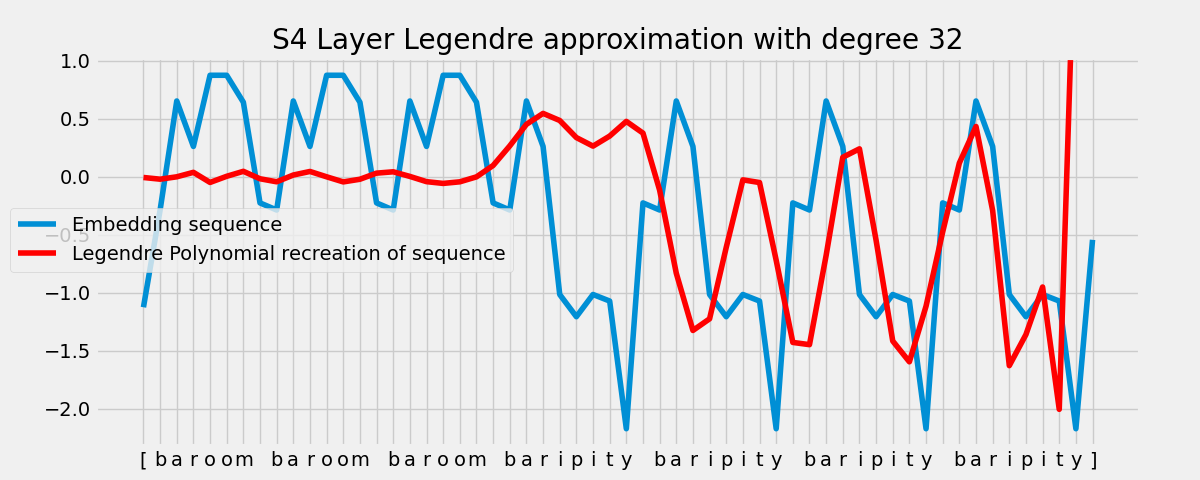

In [120]:
from matplotlib.animation import FuncAnimation, writers, PillowWriter
%matplotlib ipympl
sequence = torch.Tensor(emb_0).unsqueeze(0).unsqueeze(1).to(torch.device('mps')) # Add batch and in_channel dimension

x_rec = model.S4_layers[0].get_legendre_rec(sequence).detach().squeeze().permute(1, 0)
len(emb_0)
slides = []
# Recurrent
domain = torch.linspace(-1, 1, len(emb_0))
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.set_title('S4 Layer Legendre approximation with degree 32')
fig.set_figwidth(12)
ax.set_xticks(domain, labels=list('[baroom baroom baroom baripity baripity baripity baripity]'))
_ = ax.plot(domain, emb_0, label='Embedding sequence')[0]
line2 = ax.plot([],[], color='r', label='Legendre Polynomial recreation of sequence')[0]
fig.legend(loc='center left')
def init():  
    line2.set_data([], [])
    return line2 

def animate(idx):
    rec_coefs = x_rec[idx].squeeze().cpu()
    rec_approx = (np.polynomial.legendre.Legendre(rec_coefs)(domain).T)[len(emb_0)-idx:]
    line2.set_data(domain[:idx], rec_approx)

anim = FuncAnimation(
    fig,
    animate,
    interval=50,
    frames=len(emb_0),
    repeat_delay=100,
)
# saving to m4 using ffmpeg writer 
writergif = PillowWriter(fps=10)
anim.save('legendre_demo_32.gif',writer=writergif)

In [110]:
x_rec.shape

torch.Size([1, 1, 32, 58])